In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from scipy.spatial import distance
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import measure
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.util import invert
from skimage.morphology import skeletonize, thin, medial_axis
from scipy.ndimage import gaussian_filter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

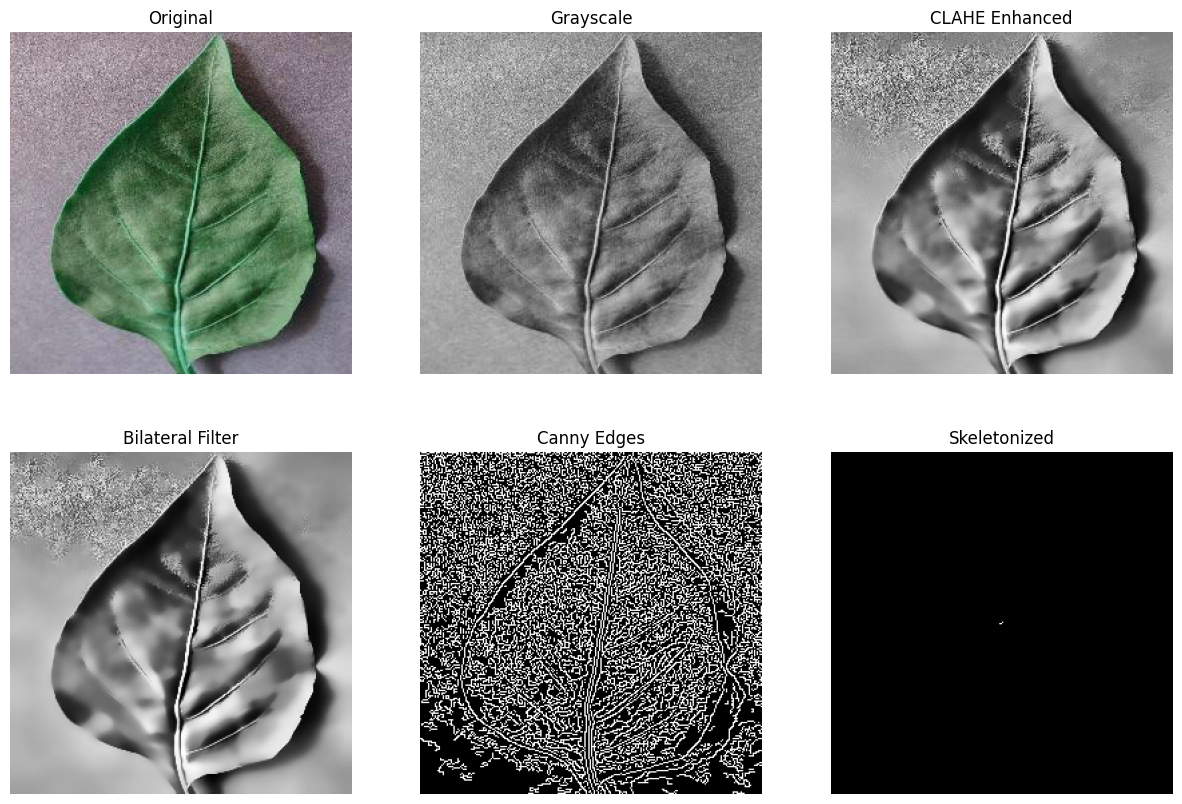

In [5]:
# Function to load and convert to grayscale
def load_and_convert_to_gray(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

# Function to apply Non-Local Means Denoising
def apply_non_local_means_denoising(gray):
    return cv2.fastNlMeansDenoising(gray, h=10, templateWindowSize=7, searchWindowSize=21)

# Function to apply Gaussian Blur
def apply_gaussian_blur(gray):
    return cv2.GaussianBlur(gray, (5, 5), 0)

# Function to apply CLAHE
def apply_clahe(gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

# Function to apply Bilateral Filter
def apply_bilateral_filter(gray):
    return cv2.bilateralFilter(gray, d=9, sigmaColor=30, sigmaSpace=1000)

# Function to apply Adaptive Thresholding
def apply_adaptive_thresholding(gray):
    return cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 5
    )

# Function to apply High-Pass Filter
def apply_high_pass_filter(gray):
    blurred_hpf = cv2.GaussianBlur(gray, (5,5), 0)
    high_pass = cv2.subtract(gray, blurred_hpf)
    return cv2.add(gray, high_pass)

# Function to apply Canny Edge Detection
def apply_canny_edge_detection(gray, min_val, max_val):
    return cv2.Canny(gray, min_val, max_val)

# Function to apply Morphological Opening
def apply_morph_opening(image, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)

# Function to calculate Hessian matrix and eigenvalues
def calculate_hessian_eigenvalues(image, sigma=3):
    hessian_matrices = hessian_matrix(image, sigma=sigma, use_gaussian_derivatives=False)
    eig1, eig2 = hessian_matrix_eigvals(hessian_matrices)
    _, binary_image = cv2.threshold(eig2, 125, 255, cv2.THRESH_BINARY)
    return binary_image

# Function to perform skeletonization
def perform_skeletonization(binary_image):
    binary_image_inverted = invert(binary_image // 255)
    return skeletonize(binary_image_inverted)

# Function to display images in subplot
def display_images(images, titles, cols=3):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(15, 5*rows))
    for i in range(len(images)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Main Code Execution
image_path = r"C:\\Users\Admin\\align_together\\plant_detection\AlignTogether\\pepper_healthy.jpg"
image, gray = load_and_convert_to_gray(image_path)

# Apply filters and transformations
denoised_nlm = apply_non_local_means_denoising(gray)
blurred = apply_gaussian_blur(gray)
enhanced = apply_clahe(denoised_nlm)
denoised_bf = apply_bilateral_filter(enhanced)
adaptive_thresh = apply_adaptive_thresholding(denoised_nlm)
high_pass = apply_high_pass_filter(gray)
edges = apply_canny_edge_detection(gray, 30, 70)
opened = apply_morph_opening(adaptive_thresh)
binary_image = calculate_hessian_eigenvalues(enhanced)
skeleton = perform_skeletonization(binary_image)

# Display images
display_images(
    [image, gray, enhanced, denoised_bf, edges, skeleton],
    ['Original', 'Grayscale', 'CLAHE Enhanced', 'Bilateral Filter', 'Canny Edges', 'Skeletonized'],
    cols=3
)
